In [23]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
import torch.utils.data
from torch.autograd import Variable
import torchvision
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
import umap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import accuracy_score, normalized_mutual_info_score, adjusted_rand_score
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import csv
import random
import plotly.graph_objs as go
from scipy.stats import mode

# Setup

In [10]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device {DEVICE}")

def seed_everything(seed=42):
    """Seed everything to make the code more reproducable."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(42)

MNIST_DIR = "/data/mnist/" # directory to store MNIST data. Set it here.
MNIST_NUM_PIXELS = 784 # 28x28


Using device cpu


# Load Data

In [11]:
train = MNIST(MNIST_DIR, train=True, download=True, transform=torchvision.transforms.ToTensor())
test = MNIST(MNIST_DIR, train=False, download=False, transform=torchvision.transforms.ToTensor())
train_dl = DataLoader(train, batch_size=256, shuffle=False)
test_dl = DataLoader(test, batch_size=256, shuffle=False)


# Loss Function

In [12]:
# update_assignments

def update_assignments(enc_output, centroids):

    distances = torch.cdist(enc_output, centroids)

    assignments = distances.argmin(dim=1)

    return assignments


# update centroids, when we initialize centroids first
def update_centroids(enc_output, assignments):

    num_clusters = torch.max(assignments).item() + 1
    centroids = torch.zeros((num_clusters, enc_output.shape[1]))

    for k in range(num_clusters):

        assigned_data = enc_output[assignments == k]

        if assigned_data.size(0) > 0:
            centroids[k] = assigned_data.mean(dim=0)

    return centroids


# WCSS loss 
def wcss(enc_output, assignments, centroids):
    device = enc_output.device  # Get the device from the enc_output tensor
    num_clusters = torch.max(assignments).item() + 1
    distance_cluster = []
    total_num_points = 0

    for i in range(num_clusters):
        sum = 0  # Reset the sum for each cluster
        x_i = enc_output[assignments == i]  # data points of i-th cluster

        if len(x_i) != 0:
            c_i = centroids[i].to(device)  # Move the centroid to the correct device

            for x in x_i:
                sum += torch.dist(x, c_i)**2

            total_num_points += len(x_i)

        distance_cluster.append(sum)

    return torch.sum(torch.Tensor(distance_cluster).to(device)) / total_num_points
    

# Reconstruction Loss = MSE
criterion = nn.MSELoss()

# Convolutional Autoencoder

In [13]:
# Define the CAE
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()   #1*28*28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),  # 8*14*14
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),  # 16*7*7
            nn.BatchNorm2d(16),  #7*7*16
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 32*4*4
            nn.BatchNorm2d(32), #4*4*32
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=0), # 64*1*1
            nn.ReLU(True),
            nn.Flatten(),   # Flatten
        )
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 1, 1)),  #Reshape  # 64*1*1
            nn.ConvTranspose2d(64, 32, 4, stride=2, output_padding=0),  #32*4*4
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 2, stride=2, padding=1, output_padding=1), # 16*7*7
            nn.BatchNorm2d(16), # 16*7*7
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1), #8*14*14
            nn.BatchNorm2d(8),  #8*14*14
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2,  padding=1, output_padding=1), #1*28*28
            nn.ReLU(True)
        )
    
    def forward(self,x):
        x = self.encoder(x)
        y = self.decoder(x)
        
        return x,y     ###....encoded, decoded

# Pre-training

In [15]:
# HayperParameters
epochs = 5
learning_rates = [0.01]
batch_sizes = [256]

# Pre-training
for lr in learning_rates:
    for batch_size in batch_sizes:
        # DataLoader
        train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        # Instantiate the model
        ModelPre = ConvAutoencoder()
        
        # Move the model to the appropriate device
        ModelPre.to(device)

        # Loss function
        criterion = nn.MSELoss()

        # Optimizer
        optimizer = torch.optim.Adam(ModelPre.parameters(), lr=lr, weight_decay=1e-5)

        # Training loop
        losses_Pre = []
        for epoch in range(1, epochs + 1):
            train_loss_Pre = 0.0
            encoded_list = []

            # Training
            for data in train_dl:
                images, _ = data
                images = images.to(device)

                encoded, decoded = ModelPre(images)
                
                loss = criterion(decoded, images)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss_Pre += loss.item() * images.size(0)
        
                # Add encoded outputs to the list
                if epoch == epochs:  # this ensures that we are only saving the encoded data from the last epoch
                    encoded_list.append(encoded.detach().cpu().numpy())

            train_loss_Pre = train_loss_Pre / len(train_dl)

            print('Epoch: {}'.format(epoch), '\tTraining Loss: {:.4f}'.format(train_loss_Pre))

            losses_Pre.append(train_loss_Pre)
        # Save the ModelPre Weights
        torch.save(ModelPre.state_dict(), f"PreWeight_LR{lr}_batch{batch_size}.pth")

        # Concatenate all encoded outputs
        encoded_data = np.concatenate(encoded_list)
        
        # Apply KMeans to the encoded data
       
        kmeans = KMeans(n_clusters=10, init='k-means++')# set n_clusters to the number of clusters you want
        kmeans.fit(encoded_data)

        # Get the centroids
        centroids = kmeans.cluster_centers_
        labels = kmeans.labels_
        
        np.save(f'PreCentroids_LR{lr}_batch{batch_size}.npy', centroids)
        np.save(f'PreLabels_LR{lr}_batch{batch_size}.npy', labels)
        
        # Converting numpy array to torch tensor
        centroids_tensor = torch.from_numpy(centroids)
        labels_tensor = torch.from_numpy(labels)

Epoch: 1 	Training Loss: 11.5081
Epoch: 2 	Training Loss: 3.7409
Epoch: 3 	Training Loss: 2.8379
Epoch: 4 	Training Loss: 2.5681
Epoch: 5 	Training Loss: 2.4038


# Stage I: Training of the Model

Epoch [1 / 30] Total_loss: 6.320407, Regularization_loss: 3.087119, clustering_loss: 3.233288
Epoch [2 / 30] Total_loss: 5.196639, Regularization_loss: 2.578721, clustering_loss: 2.617918
Epoch [3 / 30] Total_loss: 4.777661, Regularization_loss: 2.507382, clustering_loss: 2.270279
Epoch [4 / 30] Total_loss: 4.401700, Regularization_loss: 2.445540, clustering_loss: 1.956160
Epoch [5 / 30] Total_loss: 4.130916, Regularization_loss: 2.404331, clustering_loss: 1.726585
Epoch [6 / 30] Total_loss: 3.937707, Regularization_loss: 2.397533, clustering_loss: 1.540175
Epoch [7 / 30] Total_loss: 3.755440, Regularization_loss: 2.368209, clustering_loss: 1.387232
Epoch [8 / 30] Total_loss: 3.596534, Regularization_loss: 2.344249, clustering_loss: 1.252285
Epoch [9 / 30] Total_loss: 3.466671, Regularization_loss: 2.318900, clustering_loss: 1.147771
Epoch [10 / 30] Total_loss: 3.362807, Regularization_loss: 2.301088, clustering_loss: 1.061719
Epoch [11 / 30] Total_loss: 3.279509, Regularization_loss: 

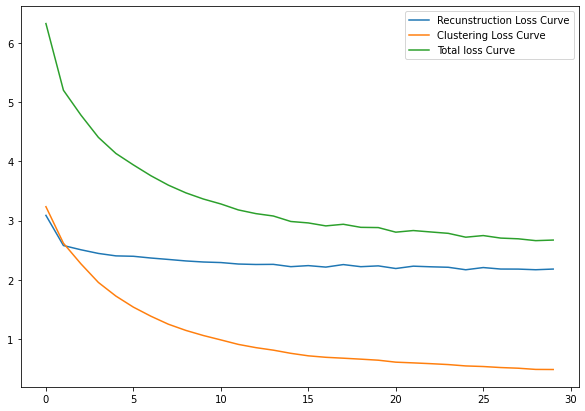

In [32]:
# HyperParameters

num_clusters = 10
learning_rates = [0.01]
batch_sizes = [256]
epochs = 30
weight_decay = 1e-5
reconstruction_weight = 1.0
separability_weight = 0.0003


# Training

for lr in learning_rates:
    for batch_size in batch_sizes:

        # DataLoader
        train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
        
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        # Instantiate the model
        modelwcss = ConvAutoencoder()
        
        # Load the model weights
        modelwcss.load_state_dict(ModelPre.state_dict())
        
        # Move the model to the appropriate device
        modelwcss.to(device)
        
        # Optimizer
        optimizer = torch.optim.Adam(modelwcss.parameters(), lr=lr, weight_decay=weight_decay)
        
        #centroids = torch.load(f"PreCentroids_LR{lr}_batch{batch_size}.pt").to(device)
        centroids = centroids_tensor
        # Saving losses value to get the plot of loss curve
        lossesR_wcss = []
        lossesC_wcss = []
        losses_wcss = []


        for epoch in range(epochs):
            
            # Monitor training loss
            TotalLossR_wcss = 0
            TotalLossC_wcss = 0
            TotalLoss_wcss = 0

            for data in train_dl:
                img, _ = data
                img = img.to(device)

                enc_wcss, dec_wcss = modelwcss(img)
                # Calculating Reconstruction loss
                lossR_wcss = reconstruction_weight * criterion(dec_wcss, img) 
                  
                # SGD-based update of cluster assignments
                assignments = update_assignments(enc_wcss, centroids).to(device) 

                # Calculating clustering loss
                lossC_wcss = separability_weight * wcss(enc_wcss.detach(), assignments, centroids).to(device)

                # Custom Loss (Regularization + Clustering)
                loss_wcss = lossR_wcss + lossC_wcss
                optimizer.zero_grad()
                loss_wcss.backward()
                optimizer.step()
                              
                # update centroids   
                centroids = update_centroids(enc_wcss, assignments).to(device)   

                TotalLossR_wcss += lossR_wcss.item() * img.size(0)
                TotalLossC_wcss += lossC_wcss.item() * img.size(0)
                TotalLoss_wcss += loss_wcss.item() * img.size(0)
                
            # len(train_dl) is the number of iterations
            TotalLossR_wcss = TotalLossR_wcss / len(train_dl)
            TotalLossC_wcss = TotalLossC_wcss / len(train_dl)
            TotalLoss_wcss = TotalLoss_wcss / len(train_dl)

            print('Epoch [%d / %d] Total_loss: %f, Regularization_loss: %f, clustering_loss: %f' % (epoch + 1, epochs, TotalLoss_wcss, TotalLossR_wcss, TotalLossC_wcss))

            lossesR_wcss.append(TotalLossR_wcss)
            lossesC_wcss.append(TotalLossC_wcss)
            losses_wcss.append(TotalLoss_wcss)


        # plot loss curve 
        plt.figure(figsize=(10, 7))
        plt.plot(lossesR_wcss, label='Recunstruction Loss Curve')
        plt.plot(lossesC_wcss, label='Clustering Loss Curve')
        plt.plot(losses_wcss, label='Total loss Curve')
        plt.legend()
        plt.savefig(f"losscurve_wcss_LR{lr}_batch{batch_size}_EP{epochs}_RP{reconstruction_weight}_CP{separability_weight}.png")
        
        # Save the state dictionary of the model
        torch.save(modelwcss.state_dict(), f"modelwcss_state_dict_LR{lr}_batch{batch_size}_EP{epochs}_RP{reconstruction_weight}_CP{separability_weight}.pth")   # save the weights
             



# Evaluation of the Model on Full MNIST Dataset

In [18]:

# Evaluation Function

def eval_fn(model, device, dl, eval_epoch):
    model.eval()
    with torch.no_grad():
        for data in dl:
            img, _ = data
            img = Variable(img)   
            img = img.to(device)
            enc, dec = model(img)  
        return enc, dec 

# Evaluation the Model
dl = DataLoader(train, batch_size=60000, shuffle=False) 

# Evaluate model and get compressed embedding
compressed_embedding, dec_eval_wcss = eval_fn(modelwcss, device, dl, 1) 

np.save(f"compressed_embedding_wcss.npy", compressed_embedding.cpu().numpy())

np.save('train_targets_wcss.npy', (train.targets).numpy())

  

# Stage II: UMAP
**we set UMAP number of components to $n_C = 2$ for the ease of visualization, and we also take $n_N = 8$.**

In [19]:

# load true labels
y_train = train.targets

# Create a list of number of components
n_components = list(range(2,3, 1))

# Create a list of number of neighbors
n_neighbors = list(range(8,9, 1))

# Loop through the number of components and number of neighbors
for n_comp in n_components:
    for n_neigh in n_neighbors:
        # Fit UMAP to the data with the current combination of n_comp and n_neigh
        refined_embedding = umap.UMAP(min_dist= 0.01, n_components=n_comp, n_neighbors=n_neigh).fit_transform(compressed_embedding)  

        np.save(f"refined_embedding_wcss_Ncomp{n_comp}_Nneigh{n_neigh}.npy", refined_embedding)
        


# Stage III: Clustering (K-means)

{'n_components': [2], 'n_neighbors': [8], 'ACC': [0.974], 'ARI': [0.943], 'NMI': [0.932]}


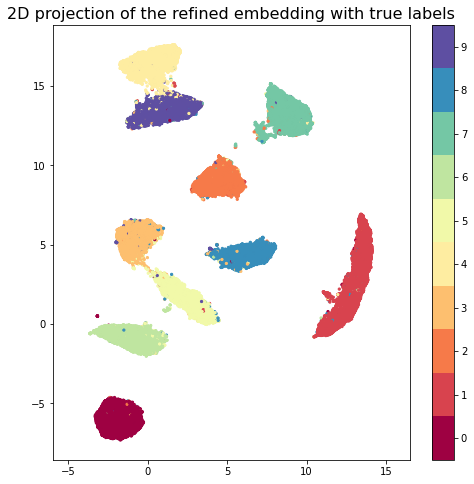

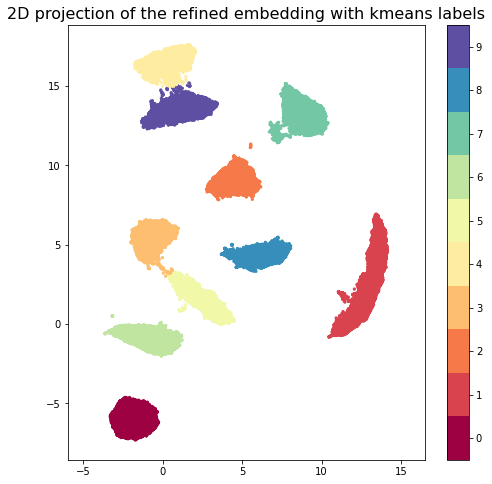

In [21]:
n_comp = 2
n_neigh = 8

# load true labels
y_true = train.targets

# Apply Kmeans
n_digits = 10
kmeans = KMeans(n_clusters=n_digits, init='k-means++')
kmeans.fit(refined_embedding)

# Get Kmeans labels as the predicted labels
y_pred = kmeans.labels_

# Create a mapping from Kmeans labels to actual labels
mapping = {pred: np.bincount(y_true[y_pred == pred]).argmax() for pred in range(n_digits)}
y_pred_mapped = np.array([mapping[label] for label in y_pred])

np.save(f"PredLabel_Mapped.npy", y_pred_mapped)

# Only plot when n_comp is 2
if n_comp == 2:

    # Create the plot with true labels
    plt.figure(figsize=(8,8))
    plt.scatter(refined_embedding[:, 0], refined_embedding[:, 1], c=y_true, cmap='Spectral', s=5)
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
    plt.title(f"2D projection of the refined embedding with true labels", fontsize=16)
    plt.savefig(os.path.join(f"RefinedEmbedding_TrueLabels.png"))
    
    
    # Create the plot with pred labels
    plt.figure(figsize=(8,8))
    plt.scatter(refined_embedding[:, 0], refined_embedding[:, 1], c=y_pred_mapped, cmap='Spectral', s=5)
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
    plt.title(f"2D projection of the refined embedding with kmeans labels", fontsize=16)
    plt.savefig(os.path.join(f"2D_RefinedEmbedding_PredLabels.png"))


# Create an empty dictionary to store the results
results_Kmeans = {'n_components': [], 'n_neighbors': [], 'ACC': [],'ARI': [], 'NMI': []}

# Calculate scores
ACC = accuracy_score(y_train, y_pred_mapped)
NMI = normalized_mutual_info_score(y_train, y_pred_mapped)
ARI = adjusted_rand_score(y_train, y_pred_mapped)

# Append the results to the dictionary
results_Kmeans['n_components'].append(n_comp)
results_Kmeans['n_neighbors'].append(n_neigh)
results_Kmeans['ACC'].append(round(ACC,3))
results_Kmeans['ARI'].append(round(ARI,3))
results_Kmeans['NMI'].append(round(NMI,3))
print(results_Kmeans)


# Stage III: Clustering (MDBSCAN)

{'n_components': [2], 'n_neighbors': [8], 'epsilon': [0.17], 'min_samples': [12], 'ACC': [0.975], 'ARI': [0.946], 'NMI': [0.934]}


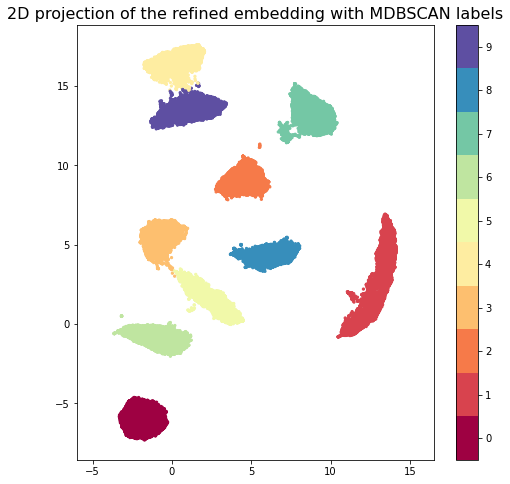

In [24]:
#### mapping function

def map_labels(y_pred, y_true):
    """
    Maps predicted labels to actual labels based on the mode (most frequent label) within each cluster.

    :param y_pred: Predicted labels (e.g., from a clustering algorithm).
    :param y_true: Actual labels (ground truth).
    :return: A tuple containing the mapped labels and the mapping dictionary.
    """
    unique_pred_labels = np.unique(y_pred)
    label_mapping = {}

    for pred_label in unique_pred_labels:
        # Find indices where the predicted label matches
        indices = np.where(y_pred == pred_label)

        # Find the most common actual label in those indices
        actual_label = mode(y_true[indices])[0][0]

        # Map the predicted label to the actual label
        label_mapping[pred_label] = actual_label

    # Map all predicted labels to the actual labels
    mapped_labels = np.array([label_mapping[label] for label in y_pred])

    return mapped_labels, label_mapping


###################################

n_comp = 2
n_neigh = 8

################################### Apply DBSCAN

epsilon = 0.17
neighbors = 12

dbscan = DBSCAN(eps = epsilon, min_samples = neighbors)
dbscan.fit(refined_embedding)
# Get the cluster labels (Assigned to each data point)
dbscan.labels_ = dbscan.labels_

from collections import Counter

def print_clusters(y_pred):
    clusters = Counter(y_pred)
    for cluster, size in clusters.items():
        if cluster == -1:
            print(f"Cluster: Noise, Size: {size}")
        else:
            print(f"Cluster: {cluster}, Size: {size}")


###################################### Get the 10 largest clusters and the clusters that are not in the 10 largest clusters
# Assuming your data is stored in the variable 'X'

X = refined_embedding

# Count occurrences of each cluster label in the predicted labels
clusters = Counter(dbscan.labels_)

# Get the 10 largest clusters
largest_clusters = sorted(clusters, key=clusters.get, reverse=True)[:10]

# Create a mask for the points in the 10 largest clusters
largest_clusters_mask = np.isin(dbscan.labels_, largest_clusters)

# Get the clusters that are not in the 10 largest clusters
small_clusters = [cluster for cluster in clusters if cluster not in largest_clusters]
small_clusters_mask = np.isin(dbscan.labels_, small_clusters)

# Create a mapping from predicted labels to true labels for the 10 largest clusters
mapping = {}
for cluster in largest_clusters:
    indices = np.where(dbscan.labels_ == cluster)[0]
    true_labels = y_train[indices]
    mapped_label = np.bincount(true_labels).argmax()  # Map to the most frequent true label
    mapping[cluster] = mapped_label

# Apply the mapping to align predicted labels with true labels for the 10 largest clusters
y_DBSCAN_mapped = np.array([mapping[label] if label in mapping else label for label in dbscan.labels_])



###################################### Reassign outliers and small clusters



# Step 1: Identify the 10 largest clusters
clusters, counts = np.unique(dbscan.labels_, return_counts=True)
top_10_clusters = clusters[np.argsort(-counts)[:10]]

# Compute centroids for the top 10 clusters
centroids = []
for cluster in top_10_clusters:
    cluster_points = refined_embedding[dbscan.labels_ == cluster]
    centroids.append(np.mean(cluster_points, axis=0))

# Step 2: Reassign points outside the 10 largest clusters
for i, point in enumerate(refined_embedding):
    if dbscan.labels_[i] not in top_10_clusters:
        # Compute distance to each centroid
        distances = [np.linalg.norm(point - centroid) for centroid in centroids]
        # Reassign to the nearest cluster
        dbscan.labels_[i] = top_10_clusters[np.argmin(distances)]

##################################### Mapping Predicted Labels

y_pred_MDBSCAN_mapped, label_mapping_eigen = map_labels(dbscan.labels_, y_train)

# Create the plot with pred labels
plt.figure(figsize=(8, 8))
plt.scatter(refined_embedding[:, 0], refined_embedding[:, 1], c=y_pred_MDBSCAN_mapped, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title(f"2D projection of the refined embedding with MDBSCAN labels", fontsize=16)
plt.savefig(os.path.join(f"2D_RefinedEmbedding_PredLabels.png"))


# Create an empty dictionary to store the results
results_MDBSCAN = {'n_components': [], 'n_neighbors': [], 'epsilon': [], 'min_samples': [], 'ACC': [], 'ARI': [], 'NMI': []}

# Calculate scores
ACC = accuracy_score(y_train, y_pred_MDBSCAN_mapped)
NMI = normalized_mutual_info_score(y_train, y_pred_MDBSCAN_mapped)
ARI = adjusted_rand_score(y_train, y_pred_MDBSCAN_mapped)

# Append the results to the dictionary
results_MDBSCAN['n_components'].append(n_comp)
results_MDBSCAN['n_neighbors'].append(n_neigh)
results_MDBSCAN['epsilon'].append(epsilon)
results_MDBSCAN['min_samples'].append(neighbors)
results_MDBSCAN['ACC'].append(round(ACC, 3))
results_MDBSCAN['ARI'].append(round(ARI, 3))
results_MDBSCAN['NMI'].append(round(NMI, 3))
print(results_MDBSCAN)